# Point source recovery for a small small image

In [1]:
import numpy as onp
import jax.numpy as jnp

In [2]:
import jax

In [3]:
from jaxri import lnprob, priors

In [6]:
from matplotlib import pyplot as plt

In [7]:
ground_truth = onp.zeros((10, 10))
ground_truth[4, 5] = 5

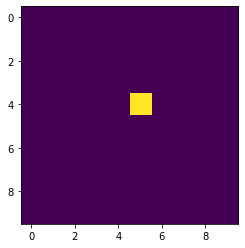

In [8]:
plt.imshow(ground_truth)

In [9]:
uv_arr = jnp.asarray(onp.loadtxt('../test-data/random_baselines.csv', delimiter=',')) * 50
model_im = jnp.asarray(ground_truth)
lm_arr = jnp.indices(model_im.shape)
vis_obs = jnp.asarray(lnprob.simulate(uv_arr, lm_arr, model_im, sigma=1))

In [10]:
uv_arr = jax.device_put(uv_arr)
lm_arr = jax.device_put(lm_arr)
vis_obs = jax.device_put(vis_obs)

In [11]:
def loss(im):
    return - jnp.sum((priors.ln_positive_number(im) + lnprob.lnprob(vis_obs, im, lm_arr, uv_arr, 1)))

In [12]:
def like(im):
    return -lnprob.lnprob(vis_obs, im, lm_arr, uv_arr, 1)

In [13]:
from jax.experimental import optimizers

In [14]:
rng = jax.random.PRNGKey(65)
init_params = jax.random.normal(rng, shape=(10, 10)) * 0.01 + 1

In [184]:
init_fun, update_fun, get_params = optimizers.sgd(1e-4)
opt_state = init_fun(init_params)

In [185]:
def update(step, opt_state):
    value, grads = jax.value_and_grad(like)(get_params(opt_state))
    opt_state = update_fun(step, grads, opt_state)
    return value, opt_state

In [186]:
j_update = jax.jit(update)

In [189]:
loss_list = []
opt_state = init_fun(init_params)
for step in range(50000):
    value, opt_state = j_update(step, opt_state)
    loss_list.append(value)

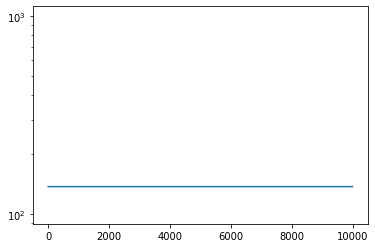

In [226]:
plt.plot(loss_list[-10000:])
plt.yscale('log')

In [58]:
def compute_i(uv: jnp.array, lm: jnp.array, vis: jnp.array):
    l, m = lm
    u, v = uv
    return jnp.sum(vis * jnp.exp(2 * jnp.pi * 1j * (u * l + v * m)))

vmapped_compute_i = jax.vmap(compute_i, in_axes=(None, 0, None))

In [201]:
lm_arr.reshape(2, 100).T.shape

(100, 2)

In [205]:
uv_arr.shape

(100, 2)

In [59]:
im_dft = vmapped_compute_i(uv_arr.T, lm_arr.reshape(2, 100).T, vis_obs)

In [60]:
im_dft.max()

DeviceArray(504.08362-2.14226j, dtype=complex64)

Note that for iDFT - I need to scale the output by 1/N where N is the total number of pixels.

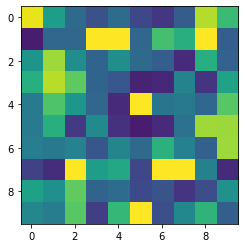

In [225]:
plt.imshow(jnp.abs(im_dft).reshape(10, 10) / abs(im_dft).max(), vmin=0., vmax=0.2)

In [214]:
abs(im_dft).max()

DeviceArray(524.10236, dtype=float32)

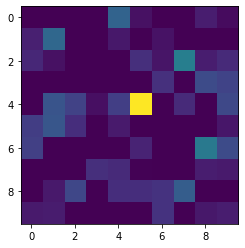

In [223]:
plt.imshow(get_params(opt_state) / get_params(opt_state).max(), vmin=0, vmax=0.2)

# Now include the prior
It looks like the gradient blows up pretty easily with SGD. But Adam seems to handle it nicely.

In [22]:
init_fun, update_fun, get_params = optimizers.adam(1e-4)
opt_state = init_fun(init_params)
def update(step, opt_state):
    value, grads = jax.value_and_grad(loss)(get_params(opt_state))
    opt_state = update_fun(step, grads, opt_state)
    return value, opt_state

In [23]:
j_update = jax.jit(update)

In [35]:
loss_list = []
opt_state = init_fun(init_params)
for step in range(50000):
    value, opt_state = j_update(step, opt_state)
    loss_list.append(value)

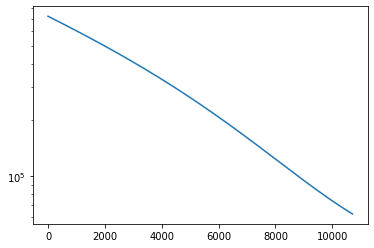

In [36]:
plt.plot(loss_list)
plt.yscale('log')

In [37]:
loss_list[-1]

DeviceArray(inf, dtype=float32)

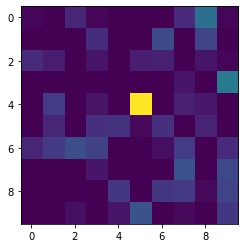

In [38]:
plt.imshow(get_params(opt_state) / get_params(opt_state).max(), vmin=0, vmax=0.2)

...the cost became inf but somehow the gradient is still there after ~12000 steps...? The image looks quite a bit worse at 12000 than it does at 50000. Oh I have (small) negative values in the pixel that's why the cost goes inf...

In practice, to enforce a prior that the pixels must be positive, we might want to do a RELU type distribution for the prior where it gets very steep for input < 0.

In [39]:
loss(get_params(opt_state))

DeviceArray(inf, dtype=float32)

# Adam on the likelihood

In [41]:
init_fun, update_fun, get_params = optimizers.adam(1e-4)
opt_state = init_fun(init_params)
def update(step, opt_state):
    value, grads = jax.value_and_grad(like)(get_params(opt_state))
    opt_state = update_fun(step, grads, opt_state)
    return value, opt_state
j_update = jax.jit(update)
loss_list = []
opt_state = init_fun(init_params)
for step in range(10000):
    value, opt_state = j_update(step, opt_state)
    loss_list.append(value)

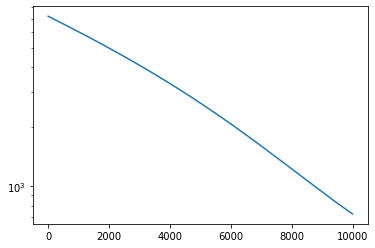

In [42]:
plt.plot(loss_list)
plt.yscale('log')

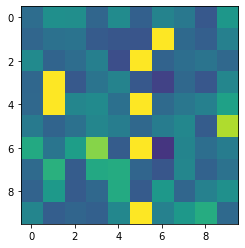

In [43]:
plt.imshow(get_params(opt_state) / get_params(opt_state).max(), vmin=0, vmax=0.2)

In [44]:
for step in range(20000):
    value, opt_state = j_update(step, opt_state)
    loss_list.append(value)

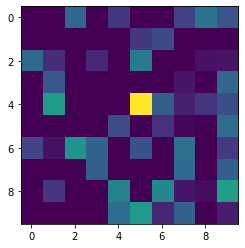

In [45]:
plt.imshow(get_params(opt_state) / get_params(opt_state).max(), vmin=0, vmax=0.2)

In [46]:
for step in range(20000):
    value, opt_state = j_update(step, opt_state)
    loss_list.append(value)

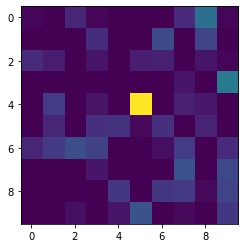

In [47]:
plt.imshow(get_params(opt_state) / get_params(opt_state).max(), vmin=0, vmax=0.2)

In [48]:
for step in range(20000):
    value, opt_state = j_update(step, opt_state)
    loss_list.append(value)

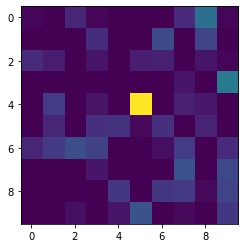

In [49]:
plt.imshow(get_params(opt_state) / get_params(opt_state).max(), vmin=0, vmax=0.2)

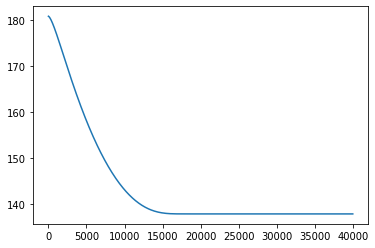

In [52]:
plt.plot(loss_list[-40000:])

Looks like the loss function is at a good place after ~45000 steps. Try higher step size?

In [53]:
init_fun, update_fun, get_params = optimizers.adam(1e-3)
opt_state = init_fun(init_params)
def update(step, opt_state):
    value, grads = jax.value_and_grad(like)(get_params(opt_state))
    opt_state = update_fun(step, grads, opt_state)
    return value, opt_state
j_update = jax.jit(update)
loss_list = []
opt_state = init_fun(init_params)
for step in range(10000):
    value, opt_state = j_update(step, opt_state)
    loss_list.append(value)

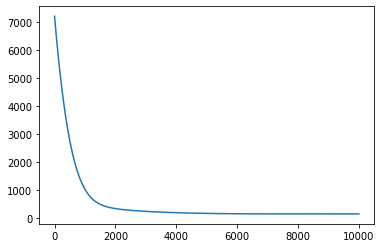

In [55]:
plt.plot(loss_list)

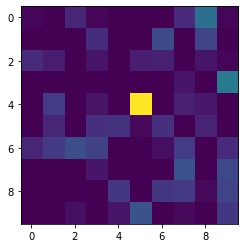

In [56]:
plt.imshow(get_params(opt_state) / get_params(opt_state).max(), vmin=0, vmax=0.2)